<div style="font-size: 50px;">
            New York Air BNB 2019</br></br>
            </div>

In [162]:
#import data analysis libraries
import pandas as pd
import numpy as np

#import models, processing library
from sklearn import model_selection, linear_model, metrics, datasets, feature_selection
from sklearn.preprocessing import LabelEncoder
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# pandas read data file
room = pd.read_csv('AB_NYC_2019.csv')

In [4]:
# remove irrevant columns such as 'latitude', 'longitude'
# room.columns
room.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
# customer id and host_id are not relevant to this model, remove them. 
# since 'neighbourhood_group' and 'neighbourhood' are not indepent, only keep 'neighbourhood'
# 'latitude' and 'longitude' are irrelevant as well, remove them

include_columns = ['name', 
       'neighbourhood','room_type',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'price']
room = room[include_columns]

In [39]:
first_day = room['last_review'].sort_values().tolist()[0]
last_day= room['last_review'].sort_values().tolist()[-1]

In [206]:
# NaN are replaced with values,
# NaN of last_review data is replaced by the earliest date in the dataset
# NaN of reviews_per_month is replaced by 0.

room['last_review']=room['last_review'].replace(np.nan, first_day)
room['reviews_per_month']=room['reviews_per_month'].replace(np.nan, 0)
room['name']=room['name'].replace(np.nan, 'unavailable')

In [375]:
entire_home = room[room['room_type'] == 'Entire home/apt']
private_home = room[room['room_type'] == 'Private room']
shared_home = room[room['room_type'] == 'Shared room']

Text(0.5, 1.0, 'Price Distribution')

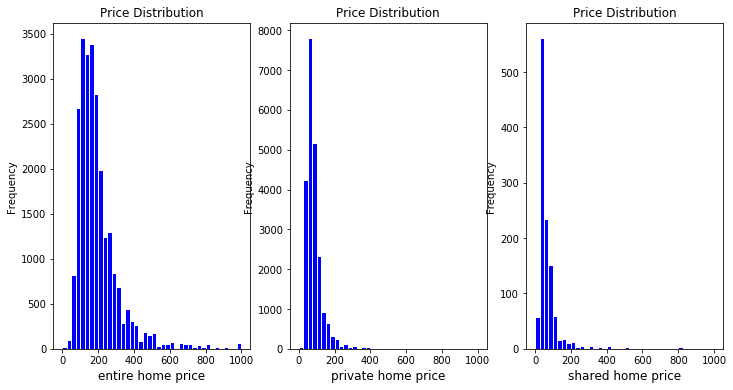

In [376]:

plt.subplot(1, 3, 1)
entire_home['price'].plot.hist(bins=40, figsize=(12, 6), edgecolor = 'white', range = [0, 1000],
                       color = 'blue')
plt.xlabel('entire home price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 3, 2)
private_home['price'].plot.hist(bins=40, figsize=(12, 6), edgecolor = 'white', range = [0, 1000],
                       color = 'blue')
plt.xlabel('private home price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 3, 3)
shared_home['price'].plot.hist(bins=40, figsize=(12, 6), edgecolor = 'white', range = [0, 1000],
                       color = 'blue')
plt.xlabel('shared home price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

<div style = "font-size: 18px; color: red">
    focus on entire home price, the other two categories can be done similarly
 </div>

In [377]:
# remove outliers, only rooms priced in the range (50, 500) are chosen

entire_home = room[(room['room_type'] == 'Entire home/apt') & (room['price'] < 500) & (room['price'] > 50)]

Text(0.5, 1.0, 'Price Distribution')

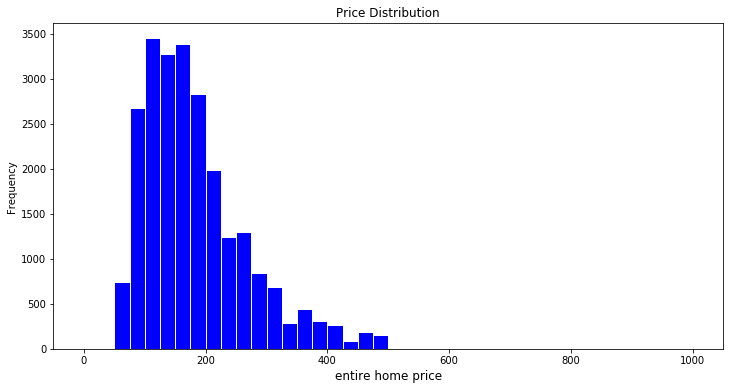

In [378]:
# prices of three types of rooms are of different scales


entire_home['price'].plot.hist(bins=40, figsize=(12, 6), edgecolor = 'white', range = [0, 1000],
                       color = 'blue')
plt.xlabel('entire home price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

Text(0.5, 1.0, 'Price Distribution')

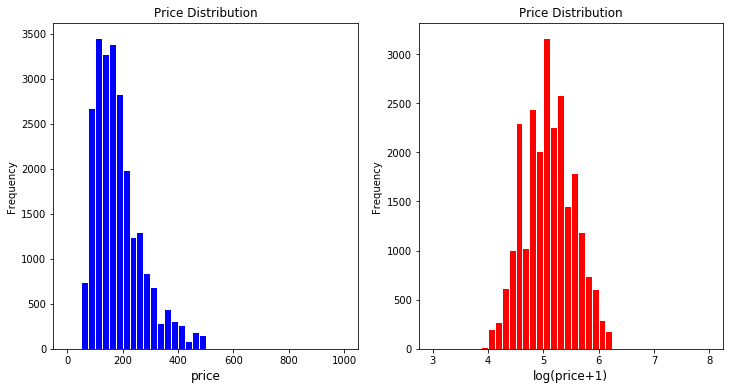

In [324]:
# Histogram of price distributions with price 
# price distribution vs price (blue)
# price distribution vs log(price + 1) (red)

plt.subplot(1, 2, 1)
entire_home['price'].plot.hist(bins=40, figsize=(12, 6), edgecolor = 'white', range = [0, 1000],
                       color = 'blue')
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(entire_home['price']+1).plot.hist(bins=40, figsize=(12, 6), edgecolor = 'white', range = [3, 8],
                            color = 'red')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

<div style = "font-size: 18px; color: red">
As for the numerical variables, the correlations with price are weak except 'availability_365'.
    </br>
    More important factors determining the price are those categorical variables.
</div>

In [367]:
# entire_home['time_to_last_review'] is defined somehow arbitrary. 
# (days to last_day + 1)/365 converted the days to the last day to years,
# for not generating 0 result, 1 is added to the number of days.
# To soomth out the scale of the variable, logrithm function is taken to the number of years,
# for not generating 0 result, 1 is added to the number of years.

entire_home.loc[:, 'time_to_last_review'] = np.log(((pd.to_datetime(last_day)\
        - pd.to_datetime(entire_home['last_review'])).dt.days + 1)/365 + 1)

In [368]:
# Room prices in different neighbourhood varies greatly. A price factor is defined in this 
# model. It is the mean price in each neighbourhood. 

neighbour_coef = entire_home[['price', 'neighbourhood']].groupby('neighbourhood').mean()
neighbour_coef.columns = ['price_factor']

In [369]:
entire_home_fit = pd.merge(entire_home, neighbour_coef, on = 'neighbourhood')

In [370]:
entire_home_fit.columns

Index(['name', 'neighbourhood', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'price',
       'time_to_last_review', 'price_factor'],
      dtype='object')

In [371]:
included_columns = ['name', 'neighbourhood', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count','availability_365',
       'time_to_last_review', 'price_factor', 'price']
entire_home_fit1 = entire_home_fit[included_columns]

In [345]:
# entire_home_fit1['minimum_nights'] = np.log1p(entire_home_fit1['minimum_nights'])
# entire_home_fit1['number_of_reviews'] = np.log1p(entire_home_fit1['number_of_reviews'])
# entire_home_fit1['reviews_per_month'] = np.log1p(entire_home_fit1['reviews_per_month'])
# entire_home_fit1['availability_365'] = np.log1p(entire_home_fit1['availability_365'])
# entire_home_fit1.head()

,name,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,time_to_last_review,price_factor,price
0,Skylit Midtown Castle,Midtown,Entire home/apt,0.693147,3.828641,2019-05-21,0.322083,2,5.874931,0.125969,226.433333,225
2,"Quiet, clean midtown apt w. elevato",Midtown,Entire home/apt,5.303305,4.532599,2019-04-30,0.641854,1,4.948760,0.175449,226.433333,110
3,"Very Central, Nomad/Chelsea Loft Studio",Midtown,Entire home/apt,2.944439,4.007333,2019-07-03,0.451076,1,4.595120,0.016305,226.433333,169
6,Stylish Studio with exclusive Terrace,Midtown,Entire home/apt,3.433987,4.919981,2019-06-19,0.896088,1,4.795791,0.053346,226.433333,190
7,"Easy, comfortable studio in Midtown",Midtown,Entire home/apt,5.902633,2.995732,2015-09-08,0.190620,1,5.902633,1.576009,226.433333,125


In [372]:
entire_home_fit1.corr()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,time_to_last_review,price_factor,price
minimum_nights,1.000000,-0.088912,-0.142441,0.135872,0.196152,0.136511,0.101706,-0.003638
number_of_reviews,-0.088912,1.000000,0.580006,-0.101662,0.199320,-0.397570,-0.135517,-0.076529
reviews_per_month,-0.142441,0.580006,1.000000,-0.067447,0.190806,-0.558820,-0.159613,-0.040457
calculated_host_listings_count,0.135872,-0.101662,-0.067447,1.000000,0.296984,0.125084,0.253070,0.154040
availability_365,0.196152,0.199320,0.190806,0.296984,1.000000,-0.159469,0.028497,0.159620
time_to_last_review,0.136511,-0.397570,-0.558820,0.125084,-0.159469,1.000000,0.154914,0.075268
price_factor,0.101706,-0.135517,-0.159613,0.253070,0.028497,0.154914,1.000000,0.425112
price,-0.003638,-0.076529,-0.040457,0.154040,0.159620,0.075268,0.425112,1.000000


In [373]:
# choose the columns stroing correlated with price

regr = linear_model.LinearRegression()

factors = ['calculated_host_listings_count', 'availability_365', 'time_to_last_review', 'price_factor']

X = entire_home_fit1[factors]
y = entire_home_fit1['price']
# msk = np.random.rand(len(entire_home_fit1)) < 0.8
# X_train, X_test, y_train, y_test = \
# X[msk], X[~msk], y[msk], y[~msk]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_train, y_train)


0.20569119685948056

In [374]:

regr.score(X_test, y_test)

0.20033469240827984

<div style = "font-size: 18px; color: red">
Next the user feedbacks to rooms are included in the model. This more complicated model involves 
    language processing.
</div>

In [81]:
# key words in user feedbacks

pd.Series(' '.join(entire_home.name).lower().split()).value_counts()[: 100]

in              7230
apartment       4457
studio          3468
bedroom         3445
apt             2635
1               2482
2               2289
the             2191
brooklyn        1932
east            1892
spacious        1882
cozy            1868
of              1717
to              1673
park            1653
with            1511
village         1474
&               1432
and             1356
private         1323
1br             1304
manhattan       1302
beautiful       1293
-               1213
heart           1208
luxury          1193
loft            1185
williamsburg    1173
sunny           1169
modern          1149
                ... 
sonder           415
heights          406
apt.             398
house            396
renovated        396
slope            379
city             375
gorgeous         366
best             361
bath             357
townhouse        342
lovely           339
hill             337
prospect         332
floor            330
suite            324
clean        